In [2]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
import brunoflow as bf
from brunoflow.ad.utils import check_node_equals_tensor, check_node_allclose_tensor
from jax import numpy as jnp
import numpy as np
import transformers
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForMaskedLM, 
    BertForMaskedLM, 
    BertTokenizer, 
    BertTokenizerFast, 
    BertEmbeddings,
    BfBertEmbeddings,
    BfBertEncoder,
    BertConfig,
    BfBertSelfAttention,
    BfBertForMaskedLM
)
from collections import Counter, OrderedDict
from typing import List, Dict, Union, Optional, Tuple
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

torch.manual_seed(0)

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


/home/kevin/miniconda3/envs/jax-hf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def convert_sentence_to_tokens_and_target_idx(sent: str, tokenizer):
    pre, target, post = sent.split("***")
    if "mask" in target.lower():
        target = ["[MASK]"]
    else:
        target = tokenizer.tokenize(target)
    tokens = ["[CLS]"] + tokenizer.tokenize(pre)
    target_idx = len(tokens)
    # print(target_idx)
    tokens += target + tokenizer.tokenize(post) + ["[SEP]"]
    return tokens, target_idx

In [4]:
# Establish data
# model_id = "google/bert_uncased_L-2_H-128_A-2"
model_id = "google/bert_uncased_L-6_H-128_A-2"
config = BertConfig.from_pretrained(pretrained_model_name_or_path="../../brunoflow/models/bert/config-tiny.json")
tokenizer = BertTokenizerFast.from_pretrained(model_id)
text = "a 1770s map of philadelphia 's naval defenses ***mask*** a fort on the island , but it is unidentified ."
good_word = "shows"
bad_word = "show"
word_ids = tokenizer.convert_tokens_to_ids([good_word, bad_word])

# tokenize text and pass into model
tokens, target_idx = convert_sentence_to_tokens_and_target_idx(text, tokenizer)
input_ids = np.expand_dims(tokenizer.convert_tokens_to_ids(tokens), axis=0)
jax_input_ids = bf.Node(jnp.array(input_ids, dtype=int), name="inputs")

print(input_ids, tokens)
# tokens = tokenizer(text, return_tensors="pt", padding=True)
# input_ids = tokens["input_ids"]
# jax_input_ids = bf.Node(jnp.array(input_ids.numpy(), dtype=int), name="inputs")
# print(input_ids, input_ids.shape)

2023-01-13 10:52:33.361460: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


[[  101  1037 17711  2015  4949  1997  4407  1005  1055  3987 13345   103
   1037  3481  2006  1996  2479  1010  2021  2009  2003 20293  1012   102]] ['[CLS]', 'a', '1770', '##s', 'map', 'of', 'philadelphia', "'", 's', 'naval', 'defenses', '[MASK]', 'a', 'fort', 'on', 'the', 'island', ',', 'but', 'it', 'is', 'unidentified', '.', '[SEP]']


In [5]:
# Create BfBertForMaskedLM model
config = BertConfig.from_pretrained(pretrained_model_name_or_path="../../brunoflow/models/bert/config-tiny.json")
bf_model = BfBertForMaskedLM.from_pretrained(model_id)

# Visualize output of forward pass of BfBertEmbeddings
bf_model.train(False)
out_bf = bf_model(input_ids=jax_input_ids).logits # shape = (vs, seq_len)
qoi = out_bf[:, target_idx] # shape = (1, vs)
qoi = qoi[:, word_ids[0]] - qoi[:, word_ids[1]] # shape = (1,)
# out_bf.visualize(collapse_to_modules=True)
# print(bf_embs)
bf_model.train(True)

qoi.backprop(values_to_compute=("max_grad",))

/home/kevin/code/rycolab/transformers/src/transformers/models/bert/modeling_bf_bert.py:178: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  bf.Parameter(jnp.zeros(self.position_ids.shape, dtype=jnp.int64), name="position_ids"),


Some weights of the model checkpoint at google/bert_uncased_L-6_H-128_A-2 were not used when initializing BfBertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BfBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BfBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/home/kevin/miniconda3/envs/jax-hf/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/home/kevin/miniconda3/envs/jax-hf/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [6]:
qoi.visualize()

/home/kevin/miniconda3/envs/jax-hf/lib/python3.9/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: neato: graph is too large for cairo-renderer bitmaps. Scaling by 0.856609 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


In [7]:
def find_matching_nodes(root: bf.Node, name: str):
    def _find_matching_nodes(root: bf.Node, name: str, visited=set()):
        assert isinstance(root, bf.Node), f"root input must be a Node, instead received {root}"
        if root in visited:
            return []
            
        matching_nodes = []
        if root.name is not None and name in root.name:
            matching_nodes.append(root)
            # return [root]
        for inp in root.inputs:
            if isinstance(inp, bf.Node):
                matching_nodes_in_subtree = _find_matching_nodes(inp, name, visited=visited)
                visited.add(inp)
                if matching_nodes_in_subtree:
                    matching_nodes = matching_nodes_in_subtree + matching_nodes
        
        return matching_nodes
    return _find_matching_nodes(root, name, visited=set())

### Does BERT use the skip or self-attention mechanism more?

In [8]:
input_to_bert_attn_nodes = find_matching_nodes(out_bf[0], "input to bertattention")


In [9]:
print(len(input_to_bert_attn_nodes)) # should match number of bert layers
print(input_to_bert_attn_nodes[-1].shape) # (1, seq_len, hidden_sz)
layer0_bert_attn_input = input_to_bert_attn_nodes[0]
print("names of parent nodes of input to bert attn:", len(layer0_bert_attn_input.get_parents()), [p.name for p in layer0_bert_attn_input.get_parents()])

6
(1, 24, 128)
names of parent nodes of input to bert attn: 4 ['matmul', 'matmul', 'matmul', 'combine self_attention_output and bert attention input 8743686542382']


In [10]:
def summarize_max_grad_parents_bert_attn_input(input_to_bert_attn_node: bf.Node, tokens: List[str]):
    # Number of hidden units corresponding to each max grad parent option (for the input to bert attention Node)
    count_hidden_unit_max_grad_parents: OrderedDict = OrderedDict({
        tokens[i]: [
            (k.name, v) for k,v in Counter(input_to_bert_attn_node.get_max_grad_parent()[0, i]).items()
        ] for i in range(len(input_to_bert_attn_node.get_max_grad_parent()[0]))
    }) # keys are tokens, values are a list of the counts of # emb units for that token which have each of the possible max grad parents

    skip_and_attn_max_grads_per_word = []
    for i in range(len(input_to_bert_attn_node.get_max_grad_parent()[0])): # each word
        max_grad_parent_for_emb = input_to_bert_attn_node.get_max_grad_parent()[0, i] # shape = (emb_sz,)
        skip_max_grad = 0
        attn_max_grad = 0
        for j in range(len(max_grad_parent_for_emb)):
            emb_unit_max_grad_val = input_to_bert_attn_node.max_grad_of_output_wrt_node[0][0][i][j]
            emb_unit_max_grad_parent = input_to_bert_attn_node.max_grad_of_output_wrt_node[1][0][i][j]
            if emb_unit_max_grad_parent.name == "matmul":
                attn_max_grad += emb_unit_max_grad_val
            elif "combine self_attention_output and bert attention input" in emb_unit_max_grad_parent.name:
                skip_max_grad += emb_unit_max_grad_val
            else:
                raise ValueError(f"uhoh! received an unexpected parent, {emb_unit_max_grad_parent}")
        skip_and_attn_max_grads_per_word.append((skip_max_grad, attn_max_grad))

    grad_diff_between_skip_and_attention = OrderedDict({tokens[i]: skip_and_attn_max_grads_per_word[i][0] - skip_and_attn_max_grads_per_word[i][1] for i in range(len(skip_and_attn_max_grads_per_word))})

    return count_hidden_unit_max_grad_parents, grad_diff_between_skip_and_attention

In [11]:
from pprint import PrettyPrinter
p = PrettyPrinter()
for layer in input_to_bert_attn_nodes:
    counts, grads = summarize_max_grad_parents_bert_attn_input(layer, tokens)
    p.pprint(counts)
    p.pprint(grads)
    print()

OrderedDict([('[CLS]',
              [('combine self_attention_output and bert attention input '
                '8743686542382',
                128)]),
             ('a',
              [('combine self_attention_output and bert attention input '
                '8743686542382',
                128)]),
             ('1770',
              [('combine self_attention_output and bert attention input '
                '8743686542382',
                110),
               ('matmul', 17),
               ('matmul', 1)]),
             ('##s',
              [('combine self_attention_output and bert attention input '
                '8743686542382',
                127),
               ('matmul', 1)]),
             ('map',
              [('combine self_attention_output and bert attention input '
                '8743686542382',
                128)]),
             ('of',
              [('combine self_attention_output and bert attention input '
                '8743686542382',
                128)]

### Does the gradient go more through the LM prediction head or the bert encoder?

In [12]:
word_embs_nodes = find_matching_nodes(qoi, "emb weights (30522")
assert len(word_embs_nodes) == 1
word_embs_node = word_embs_nodes[0]
word_embs_per_token_node = word_embs_node[input_ids]
word_embs_per_token_node.max_grad_of_output_wrt_node = (word_embs_node.max_grad_of_output_wrt_node[0][input_ids], word_embs_node.max_grad_of_output_wrt_node[1][input_ids])
word_embs_per_token_node.max_neg_grad_of_output_wrt_node = (word_embs_node.max_neg_grad_of_output_wrt_node[0][input_ids], word_embs_node.max_neg_grad_of_output_wrt_node[1][input_ids])
word_embs_per_token_node.parents = word_embs_node.parents

In [13]:
word_embs_per_token_node.shape

(1, 24, 128)

In [14]:
[p.name for p in word_embs_per_token_node.get_parents()]

['get_embedding', 'transpose']

In [15]:
def summarize_max_neg_grad_word_embs(word_embs_node: bf.Node, tokens: List[str]):
    # Number of hidden units corresponding to each max grad parent option (for the input to bert attention Node)
    count_hidden_unit_max_grad_parents: OrderedDict = OrderedDict({
        tokens[i]: [
            (k.name, v) for k,v in Counter(word_embs_node.get_max_neg_grad_parent()[0, i]).items()
        ] for i in range(len(word_embs_node.get_max_neg_grad_parent()[0]))
    }) # keys are tokens, values are a list of the counts of # emb units for that token which have each of the possible max grad parents

    max_grad_buckets_for_all_words = []
    parent_names = [p.name for p in word_embs_node.get_parents()]
    for i in range(len(word_embs_node.get_max_neg_grad_parent()[0])): # each word
        max_grad_parent_for_emb = word_embs_node.get_max_neg_grad_parent()[0, i] # shape = (emb_sz,)
        max_grad_buckets = dict.fromkeys(parent_names, 0.)
        for j in range(len(max_grad_parent_for_emb)):
            emb_unit_max_grad_val = word_embs_node.max_neg_grad_of_output_wrt_node[0][0][i][j]
            emb_unit_max_grad_parent = word_embs_node.max_neg_grad_of_output_wrt_node[1][0][i][j]
            max_grad_buckets[emb_unit_max_grad_parent.name] += emb_unit_max_grad_val

        max_grad_buckets_for_all_words.append((max_grad_buckets[parent_names[0]], max_grad_buckets[parent_names[1]]))

    grad_diff_between_skip_and_attention = OrderedDict({**{"parent_names": parent_names}, **{tokens[i]: max_grad_buckets_for_all_words[i][0] - max_grad_buckets_for_all_words[i][1] for i in range(len(max_grad_buckets_for_all_words))}})

    return count_hidden_unit_max_grad_parents, grad_diff_between_skip_and_attention

In [16]:
summarize_max_neg_grad_word_embs(word_embs_per_token_node, tokens)

(OrderedDict([('[CLS]', [('get_embedding', 128)]),
              ('a', [('get_embedding', 128)]),
              ('1770', [('get_embedding', 128)]),
              ('##s', [('get_embedding', 128)]),
              ('map', [('get_embedding', 128)]),
              ('of', [('get_embedding', 128)]),
              ('philadelphia', [('get_embedding', 128)]),
              ("'", [('get_embedding', 128)]),
              ('s', [('get_embedding', 128)]),
              ('naval', [('get_embedding', 128)]),
              ('defenses', [('get_embedding', 128)]),
              ('[MASK]', [('get_embedding', 128)]),
              ('fort', [('get_embedding', 128)]),
              ('on', [('get_embedding', 128)]),
              ('the', [('get_embedding', 128)]),
              ('island', [('get_embedding', 128)]),
              (',', [('get_embedding', 128)]),
              ('but', [('get_embedding', 128)]),
              ('it', [('get_embedding', 128)]),
              ('is', [('get_embedding', 128)]),
      

Conclusion: grad entirely goes through the bert encoder

### How does gradient travel through key/value/query structures per layer?

In [17]:
# Distinguish the matmul parents
for input_to_bert_attn_layer in input_to_bert_attn_nodes:
    for parent in input_to_bert_attn_layer.get_parents():
        curr_parent = parent
        if curr_parent.name == "matmul":
            while "bertselfattention" not in curr_parent.name:
                assert len(curr_parent.get_parents()) == 1
                curr_parent = curr_parent.get_parents()[0]
            parent.name = f"matmul ({curr_parent.name})"


In [18]:
Token = str
NodeName = str

In [31]:
def summarize_max_neg_grad_kvq(input_to_bert_attn_node: bf.Node, tokens: List[str]):
    # Number of hidden units corresponding to each max grad parent option (for the input to bert attention Node)
    count_hidden_unit_max_grad_parents: OrderedDict[Token, List[Tuple[NodeName, int]]] = OrderedDict({
        i: [
            (k.name, v) for k,v in Counter(input_to_bert_attn_node.get_max_neg_grad_parent()[0, i]).items()
        ] for i in range(len(input_to_bert_attn_node.get_max_neg_grad_parent()[0]))
    }) # keys are tokens, values are a list of the counts of # emb units for that token which have each of the possible max grad parents

    max_grad_buckets_for_all_words = []
    parent_names = [p.name for p in input_to_bert_attn_node.get_parents()]
    for i in range(len(input_to_bert_attn_node.get_max_neg_grad_parent()[0])): # each word
        max_grad_parent_for_emb = input_to_bert_attn_node.get_max_neg_grad_parent()[0, i] # shape = (emb_sz,)
        max_grad_buckets = dict.fromkeys(parent_names, 0.)
        for j in range(len(max_grad_parent_for_emb)):
            emb_unit_max_grad_val = input_to_bert_attn_node.max_neg_grad_of_output_wrt_node[0][0][i][j]
            emb_unit_max_grad_parent = input_to_bert_attn_node.max_neg_grad_of_output_wrt_node[1][0][i][j]
            max_grad_buckets[emb_unit_max_grad_parent.name] += emb_unit_max_grad_val

        max_grad_buckets_for_all_words.append(max_grad_buckets)

    grad_per_parent_per_word: OrderedDict[Token, List[Dict[NodeName, float]]] = OrderedDict({i: max_grad_buckets_for_all_words[i] for i in range(len(max_grad_buckets_for_all_words))})

    return count_hidden_unit_max_grad_parents, grad_per_parent_per_word

In [20]:
count_hidden_unit_max_grad_parents, grad_per_parent_per_word = summarize_max_neg_grad_kvq(input_to_bert_attn_nodes[-3], tokens)

In [60]:
import math
def plot_grad_per_parent_per_word_for_all_layers(input_to_bert_attn_nodes, tokens, layer_nums=None, remove_mask=False, cut_off_outliers=True):
    if layer_nums is None:
        layer_nums = range(len(input_to_bert_attn_nodes))
    rows, cols = math.ceil(len(input_to_bert_attn_nodes) / 2), 2
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 16))
    fig.suptitle("Amount of max grad passing through each path in BertAttention Layers")
    for layer_num in layer_nums:
        ax = axes[layer_num // cols, layer_num % cols]
        grad_per_parent_per_word_df = preprocessgrad_per_parent_per_word_data_for_layer(input_to_bert_attn_nodes=input_to_bert_attn_nodes, layer_num=layer_num, remove_mask=remove_mask)
        plot_grad_per_parent_per_word_for_layer(grad_per_parent_per_word_df, tokens, layer_num=layer_num, ax=ax, use_legend=(layer_num == layer_nums[-1]), cut_off_outliers=cut_off_outliers)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.tight_layout()
    plt.show()

def plot_grad_per_parent_per_word_for_layer(grad_per_parent_per_word_df, tokens, layer_num: int, ax=None, use_legend=False, cut_off_outliers=False):
    # this assumes the "token" key of grad_per_parent_per_word_df contains values from [0, len(tokens) - 1], with each index mapping to the token
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    # plt.figure(figsize=(10,6))
    sns.lineplot(data=grad_per_parent_per_word_df, x="token", y="path grad", hue="path_name", hue_order=sorted(grad_per_parent_per_word_df["path_name"].unique()), legend=use_legend, ax=ax)
    # plt.xticks(rotation=45)
    if cut_off_outliers:
        ylim_bottom = grad_per_parent_per_word_df["path grad"].mean() - 2 * grad_per_parent_per_word_df["path grad"].std()
        ax.set_ylim(bottom=ylim_bottom, top=0)
    # if grad_per_parent_per_word_df["path grad"]
    ax.set_xticks(ticks=sorted(grad_per_parent_per_word_df["token"].unique()), labels=tokens)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    # ax.set_xticks(tokens)
    ax.set_title(f"Layer {layer_num}", wrap=True)
    return ax
    # plt.show()
    # return fig

def preprocessgrad_per_parent_per_word_data_for_layer(input_to_bert_attn_nodes, layer_num: int, remove_mask=False):
    _, grad_per_parent_per_word = summarize_max_neg_grad_kvq(input_to_bert_attn_nodes[layer_num], tokens)
    grad_per_parent_per_word_df = pd.DataFrame(grad_per_parent_per_word)
    grad_per_parent_per_word_df = grad_per_parent_per_word_df.reset_index(names=["path_name"])
    grad_per_parent_per_word_df = grad_per_parent_per_word_df.melt(id_vars=["path_name"], var_name="token", value_name="path grad") # ["variable"].value_counts()
    grad_per_parent_per_word_df["path grad"] = grad_per_parent_per_word_df["path grad"].astype(float)
    grad_per_parent_per_word_df["path_name"] = grad_per_parent_per_word_df["path_name"].apply(
        lambda x: "skip layer" if "combine" in x else x
    )
    grad_per_parent_per_word_df["layer_num"] = layer_num
    if remove_mask:
        grad_per_parent_per_word_df = grad_per_parent_per_word_df[grad_per_parent_per_word_df["token"] != "[MASK]"]

    return grad_per_parent_per_word_df

def preprocessgrad_per_parent_per_word_data_per_layer(input_to_bert_attn_nodes, remove_mask=False):
    return pd.concat(
        [
            preprocessgrad_per_parent_per_word_data_for_layer(input_to_bert_attn_nodes, layer_num, remove_mask=remove_mask) for layer_num in range(len(input_to_bert_attn_nodes))
        ], 
        axis=0
    )


In [33]:
grad_per_parent_per_word_per_layer_df = preprocessgrad_per_parent_per_word_data_per_layer(input_to_bert_attn_nodes)

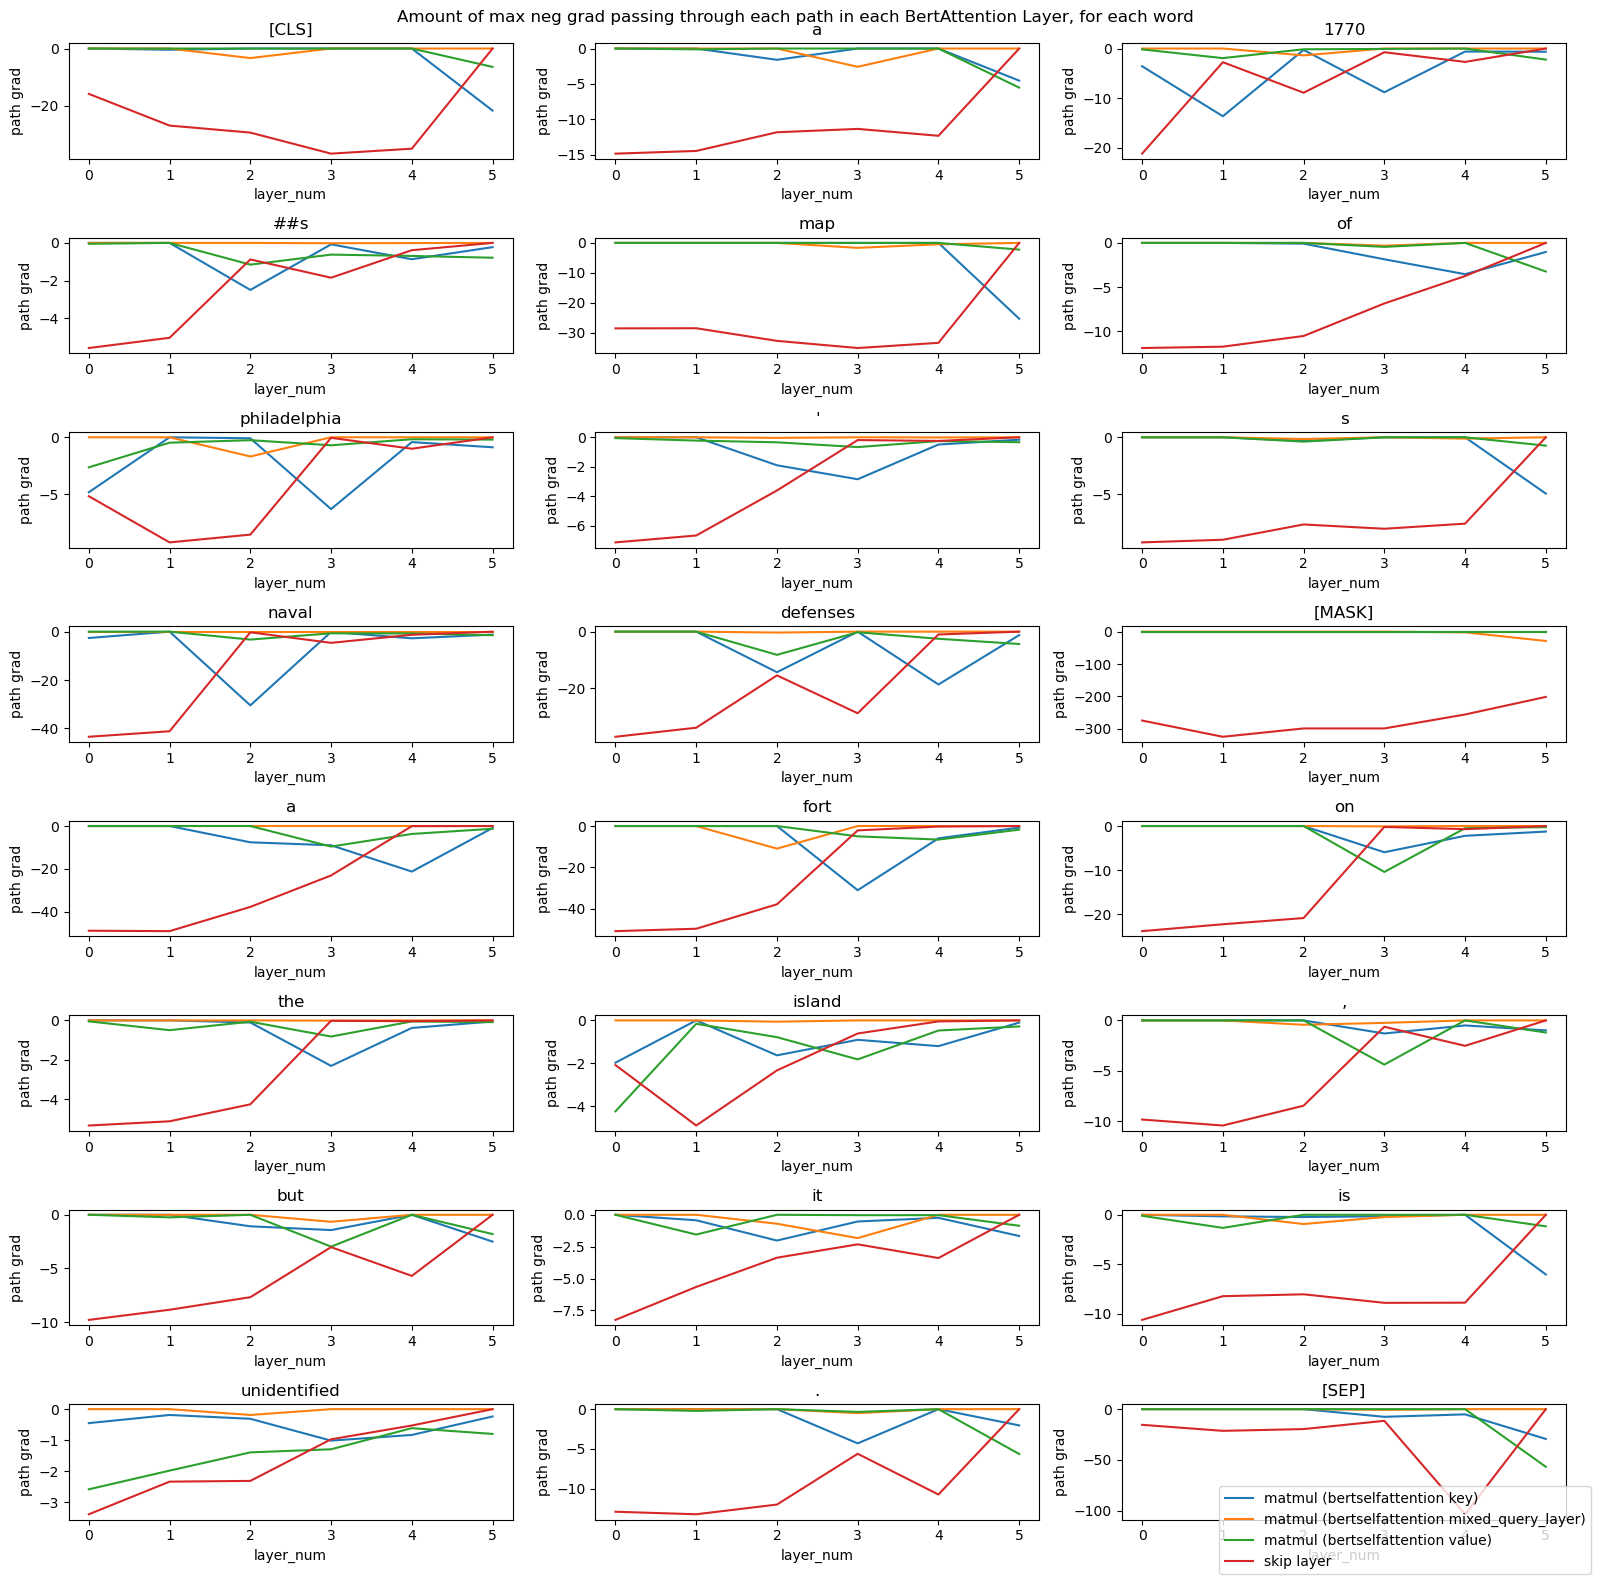

In [37]:
# Plot the grad on y axis and layer on x axis for each word in the sentence
# tokens = grad_per_parent_per_word_per_layer_df["token"].unique()
rows = math.ceil(len(tokens) / 3)
cols = 3 
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 16))
fig.suptitle("Amount of max neg grad passing through each path in each BertAttention Layer, for each word", wrap=True)

for token_num, token in enumerate(tokens):
    ax = axes[token_num // cols, token_num % cols]
    data = grad_per_parent_per_word_per_layer_df[grad_per_parent_per_word_per_layer_df["token"] == token_num]
    use_legend = (token_num == len(tokens) - 1)
    sns.lineplot(data=data, x="layer_num", y="path grad", hue="path_name", hue_order=sorted(grad_per_parent_per_word_per_layer_df["path_name"].unique()), legend=use_legend,ax=ax)
    ax.set_title(token)
plt.tight_layout()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
ax.get_legend().remove()
plt.show()

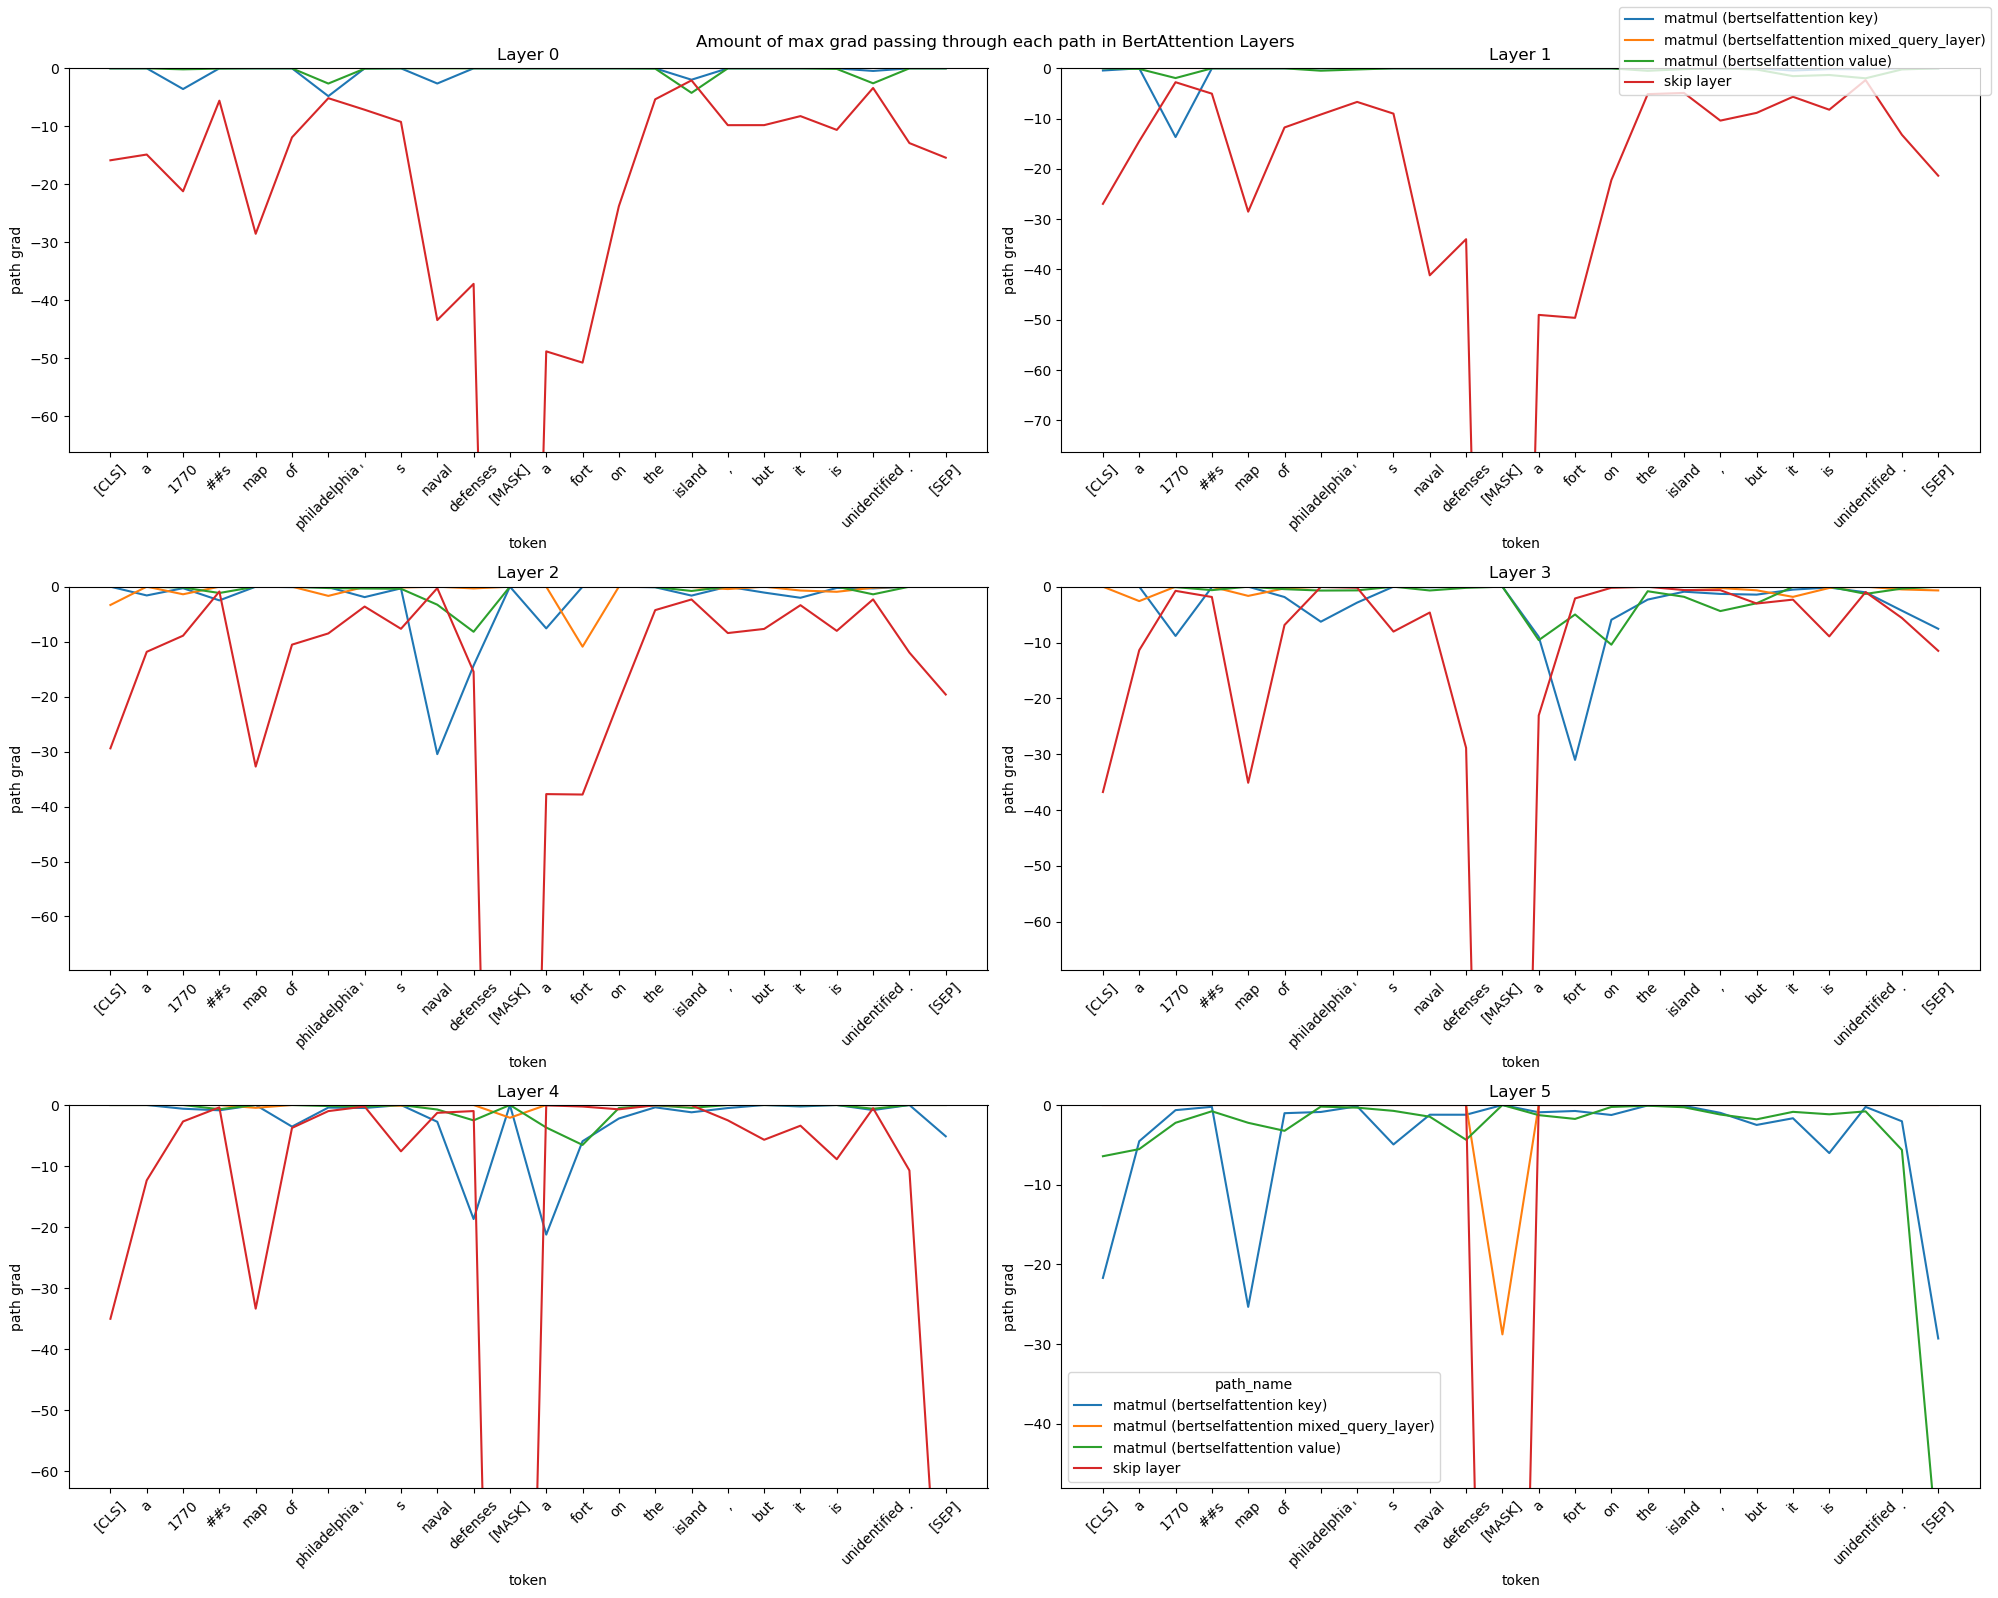

In [62]:
plot_grad_per_parent_per_word_for_all_layers(input_to_bert_attn_nodes, tokens)

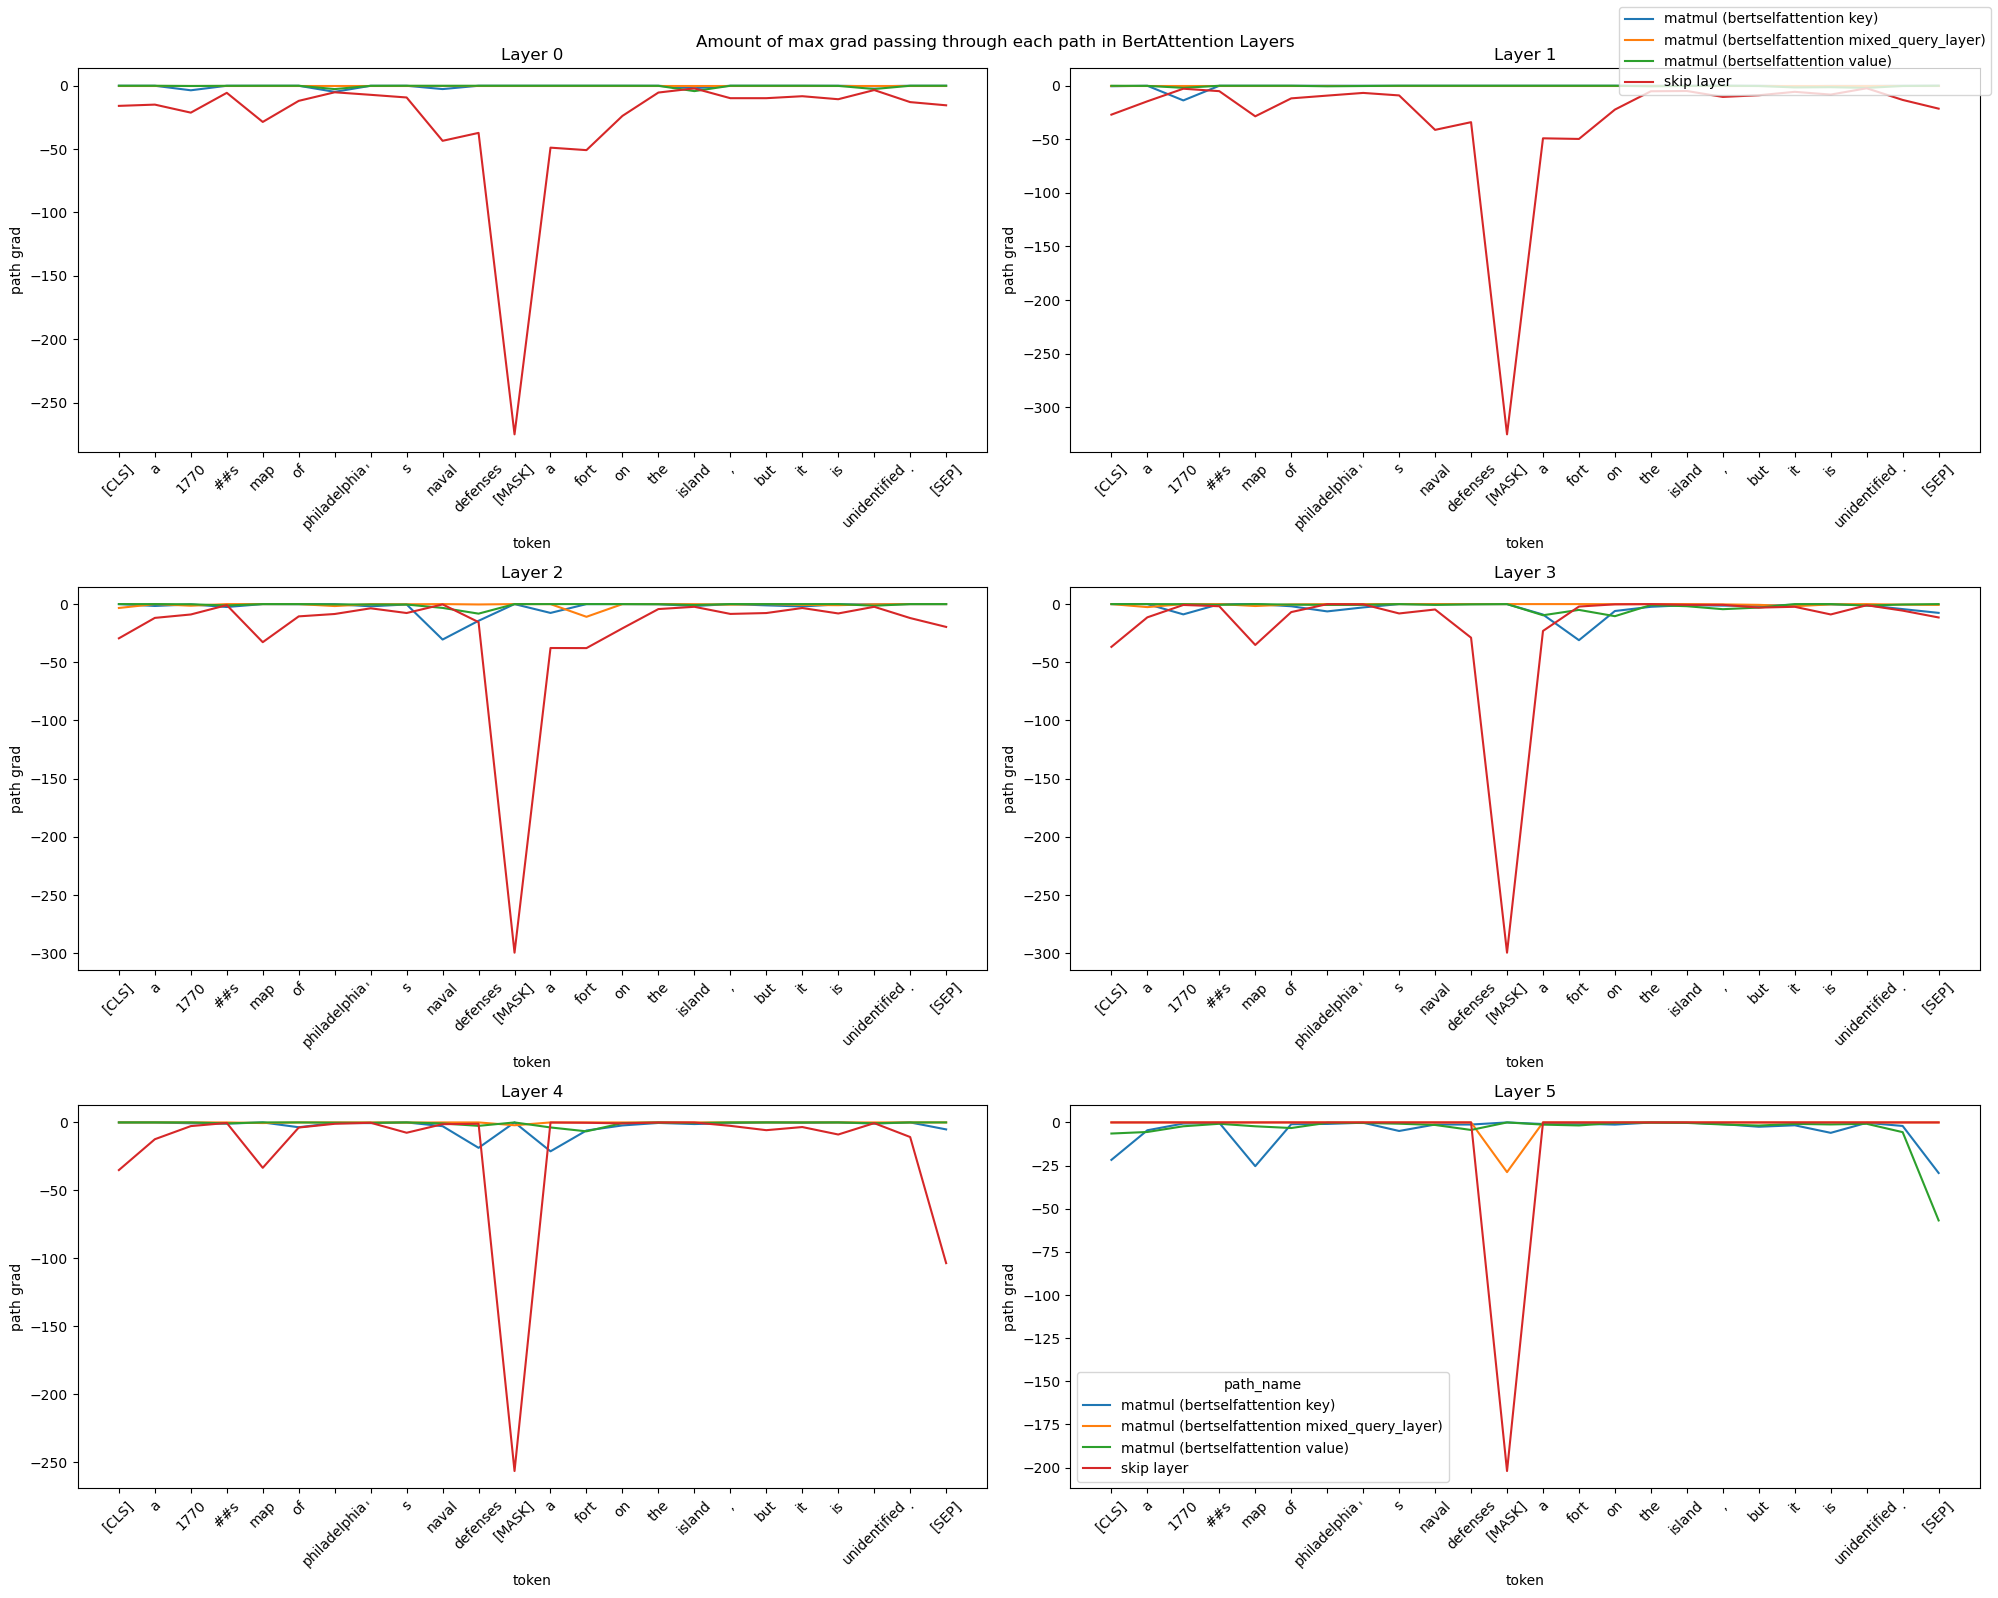

In [63]:
plot_grad_per_parent_per_word_for_all_layers(input_to_bert_attn_nodes, tokens, remove_mask=True, cut_off_outliers=False)

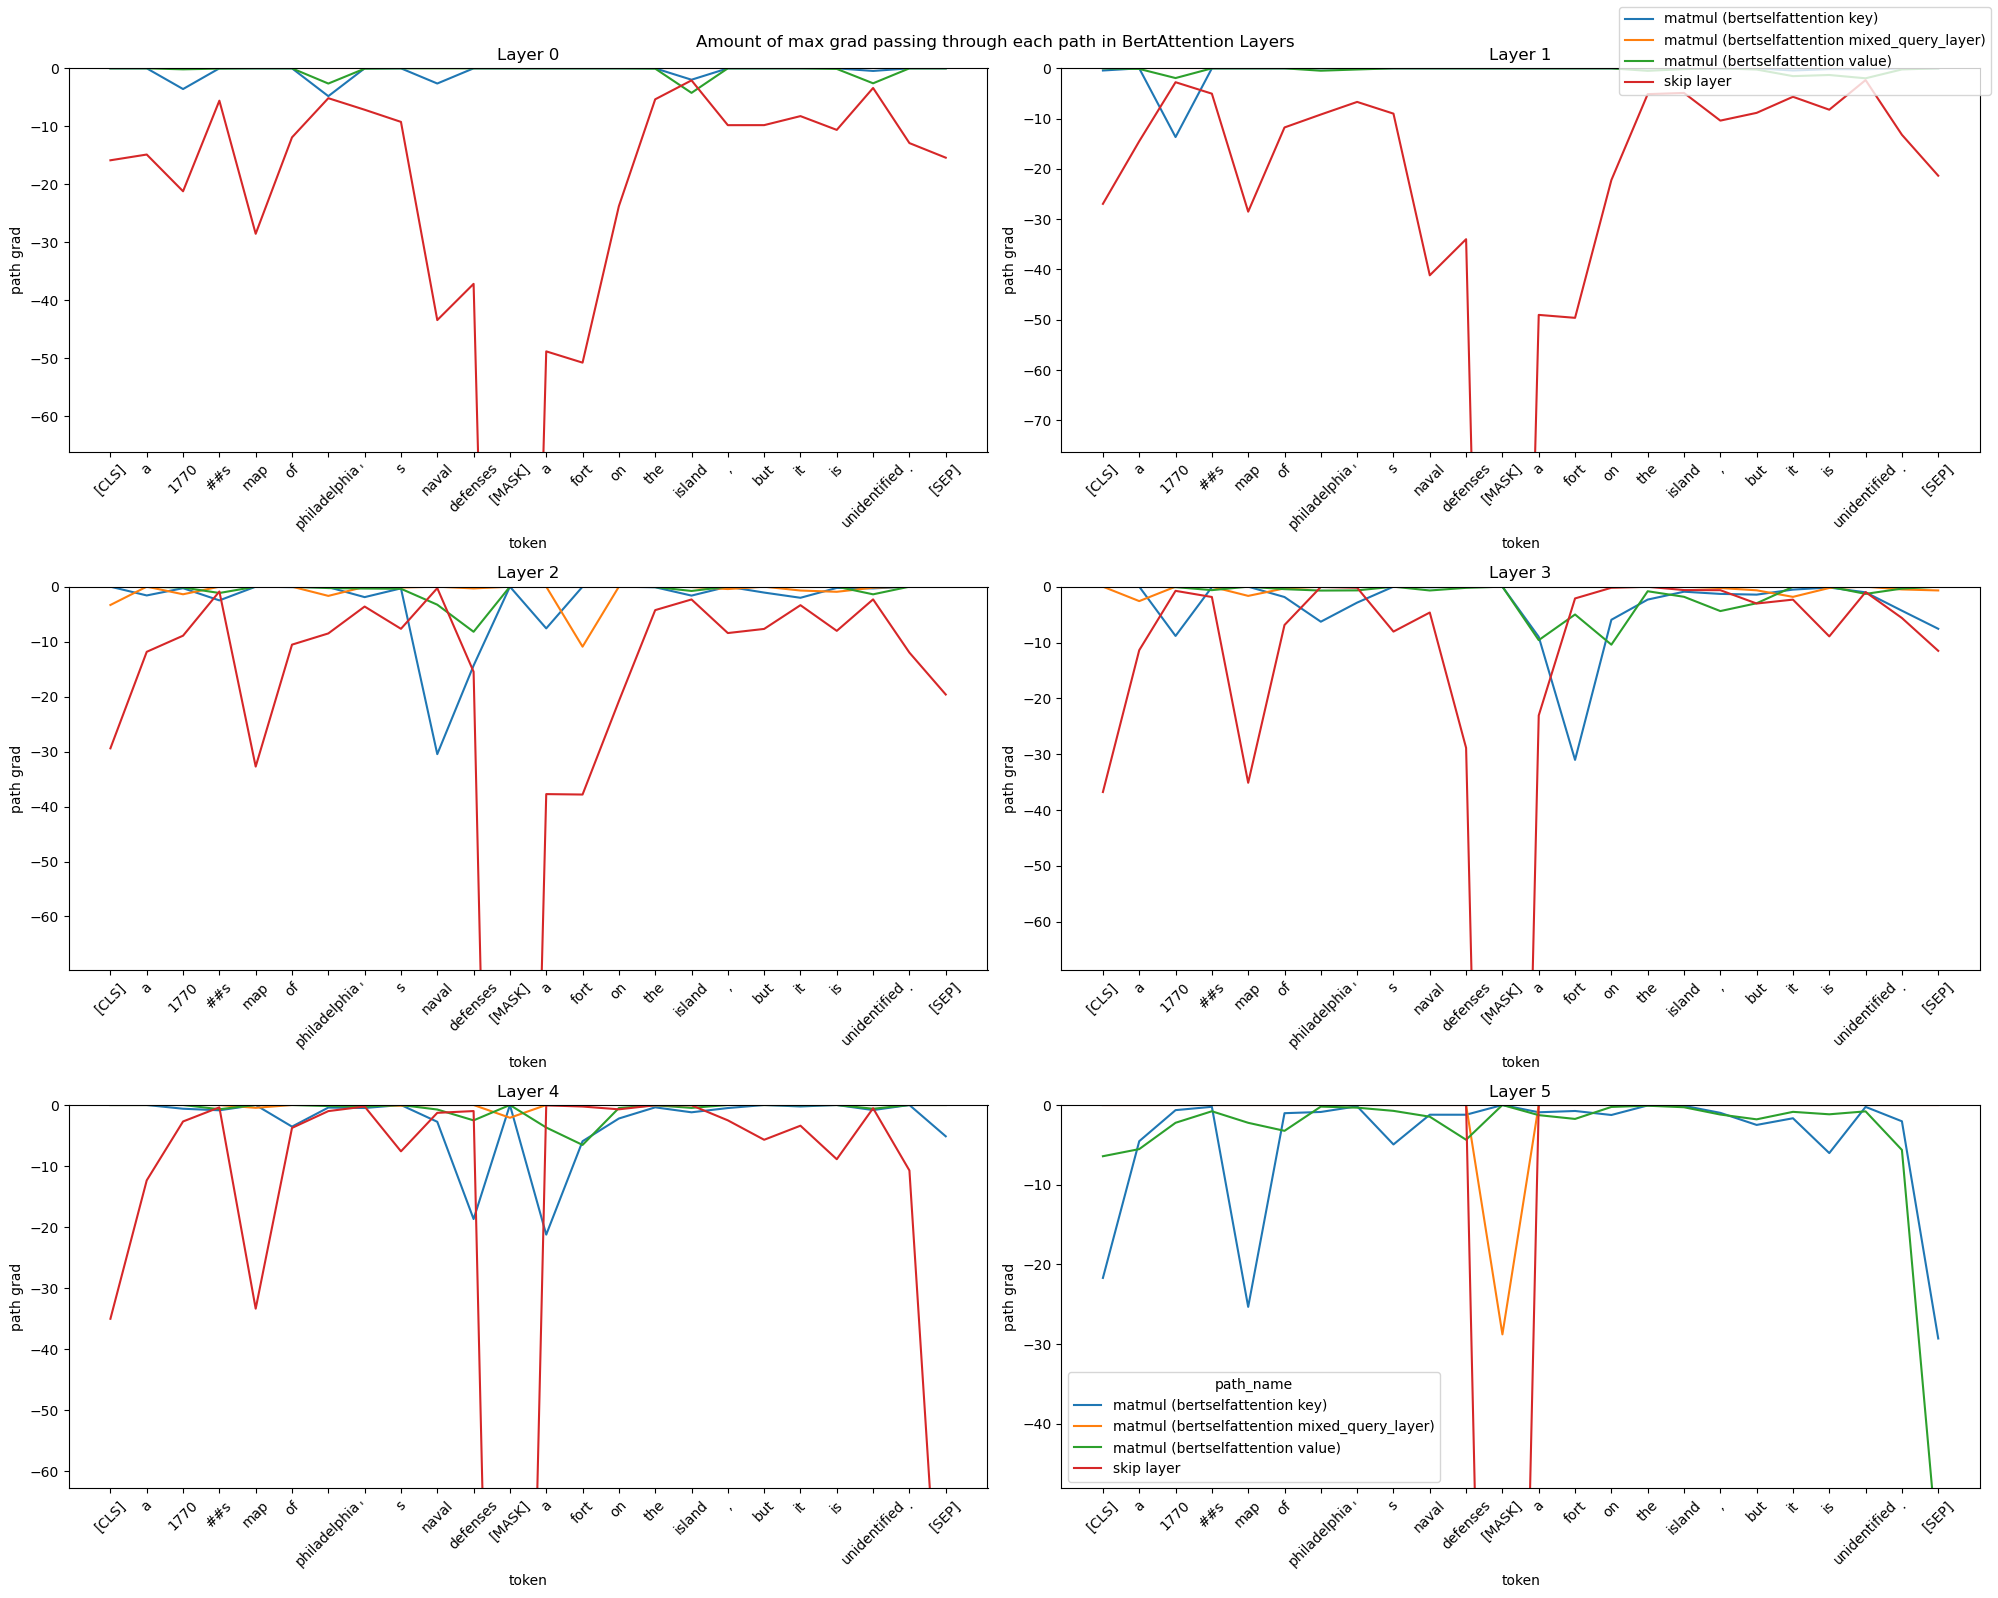

In [64]:
plot_grad_per_parent_per_word_for_all_layers(input_to_bert_attn_nodes, tokens, remove_mask=True, cut_off_outliers=True)

In [ ]:
grad_per_parent_per_word_df = pd.DataFrame(grad_per_parent_per_word)
grad_per_parent_per_word_df
grad_per_parent_per_word_df = grad_per_parent_per_word_df.reset_index(names=["path_name"])
grad_per_parent_per_word_df = grad_per_parent_per_word_df.melt(id_vars=["path_name"], var_name="token", value_name="path grad") # ["variable"].value_counts()
grad_per_parent_per_word_df["path grad"] = grad_per_parent_per_word_df["path grad"].astype(float)
grad_per_parent_per_word_df["layer_num"] = 0
pd.concat([grad_per_parent_per_word_df, grad_per_parent_per_word_df], axis=0)


,path_name,token,path grad,layer_num
0,combine self_attention_output and bert attenti...,[CLS],36.788231,0
1,matmul (bertselfattention key),[CLS],0.000000,0
2,matmul (bertselfattention mixed_query_layer),[CLS],0.000000,0
3,matmul (bertselfattention value),[CLS],0.000000,0
4,combine self_attention_output and bert attenti...,a,22.706457,0
...,...,...,...,...
87,matmul (bertselfattention value),.,0.347181,0
88,combine self_attention_output and bert attenti...,[SEP],11.503683,0
89,matmul (bertselfattention key),[SEP],7.537046,0
90,matmul (bertselfattention mixed_query_layer),[SEP],0.676849,0
